Q1. A database table of samples of the historical Freddie Mac single-family loan level data has been provided for this exercise. See the Appendix for details about how to connect to this database and the schema of the table. You will need to create Python scripts that connect to this database table and process the data in the table to fill the needs of the following requirements.

In [1]:
import pymysql
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

cnt = pymysql.connect(host='miniproject-qfa.cef17qxjlavg.us-west-2.rds.amazonaws.com',
                      port=int(3306),user='newuser',passwd='unisonim2.0',db='AgencyData')
df = pd.read_sql('Select * FROM CleanFreddieSample',cnt)
df.tail(1)

,first_pmt_date,age,status,first_time_ho_flag,msa_code,mi_pct,credit_score,num_units,occupancy_status,orig_cltv,orig_dti,orig_upb,orig_ir,prop_type,state,zip,loan_seq_num,loan_purpose,num_borrowers
19999,200311,113.0,Prepay,,36420.0,000,773.0,1,O,64,23,272000,5.625,SF,OK,73000,F103Q3437940,N,2.0


Q2. We would like to analyze the breakdown of mortgage statuses (prepay, default, alive) for each
origination cohort (group by year of first_pmt_date). Graph the count and percentage of mortgages in
each status (stacked y-axis) by origination cohort (x-axis). Comment on the change in mortgage behavior
through the mortgage origination cycle.

<AxesSubplot:xlabel='year'>

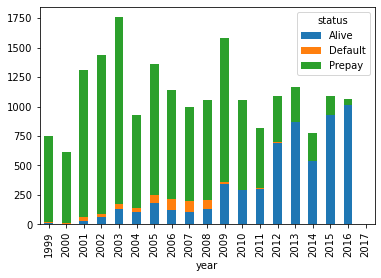

In [2]:
import matplotlib.pyplot as plt

year = df['first_pmt_date'].str[:4]
df['year'] = year.astype(int)
month = df['first_pmt_date'].str[4:]
df['month'] = month.astype(int)
yearstatus = df.groupby(['year','status'])['status'].count().unstack('status').fillna(0)
yearstatus.plot(kind='bar', stacked=True)
#print(yearstatus)

comment: The status majority change from Prepay to alive gradually from 1999 to 2017

Q3. Repeat the analysis above and show the results, but instead of grouping the mortgages by
first_pmt_date, group them by age. In addition, briefly explain how you would go about building
prepayment and default models for residential mortgages. Separately, what specific empirical data would
be required if we want to build a turnover model for Unison residential equity agreements (REA)?
Describe a statistical method you would use to estimate the parameters based on such data for an
assumed Unison turnover model.

<AxesSubplot:xlabel='ageunder'>

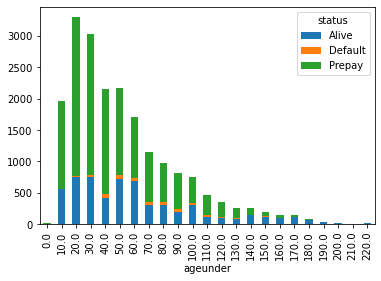

In [3]:
ageunder = (df['age']//10+1)*10
df['ageunder'] = ageunder
agestatus = df.groupby(['ageunder','status'])['status'].count().unstack('status').fillna(0)
agestatus.plot(kind='bar', stacked=True)
#print(agestatus)

Comment: Emperically, mortgage age and interest rates are the two main factors that drive the mortgage turnover model. 

One basic turnover model is constant percent prepayment (CPP), the CPP model is an annualized estimatation of mortgage prepayments, computed by multiplying the average monthly prepayment rate by 12.

Q4. How could prepayment or default behavior of the mortgage affect the Unison residential equity
agreement (REA) on the same home? Separately, please share your intuition about how a REA’s turnover
behavior may change under different market conditions (interest rates, home price appreciation, etc.).
Determine the following unconditional probabilities of mortgage behavior based on the sample data and
describe how you arrive at your results. Be reminded that total probabilities should sum up to 1.
-That a mortgage has defaulted in the first 5 years
-That a mortgage has prepaid in the first 5 years
-That a mortgage remains alive after the first 5 years

In [4]:
conda = df[(df.age <= 60) & (df.status == 'Default')]
condb = df[(df.age <= 60) & (df.status == 'Prepay')]
condc = df[df.age > 60]
condtotal = len(conda) + len(condb) + len(condc)
print(len(conda)/condtotal,len(condb)/condtotal,len(condc)/condtotal)

0.014538676607642124 0.6424976700838769 0.3429636533084809


Comment: Prepayment or default bahavior analysis is essential to REA on the same home because it can effectively support the risk management of the firm operation. We may Manage portfolio risk under various interest rate and market scenarios.

A higher interest rates leads to higher default rate because it tend to make the mortgage unaffordable.
A hime price appreciation leads to lower default rate because the borrower will have more loss once default.

These three senarios does not sum up to the total sample size because it can not categorize the following senario: a mortgage that remains alive in the first 5 years. The conditional probabilities of the three mortgage behaviors do not sum up to 1 thus i will use conditional probability in calculation.

The following probabilities for {default in 5, prepaid in 5, alive after 5} = {1.45%,64.25%,34.30%}

Q5. Select either prepayment or default as a response. Select one or more factors (from the list of
mortgage characteristics in the provided table) which you believe would affect the selected response and
build a simple model to predict prepayment or default rates. Comment on how your selected response
(prepayment or default) might affect the market price of a mortgage and how you could devise an
investment strategy around this model’s output. Use out-of-sample testing to validate your model. Feel
free to highlight if you have additional thoughts on how you could further improve the model.

In [5]:
#calculating the months since start date
monthssince = (2016 - df['year'])*12 + (12-df['month'])+4
df['monthssince'] = monthssince
import sklearn
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split
#only takes default and prepayment and remove NaN in credit score
df_q5 = df[(df.status != 'Alive')&(df.credit_score >= 0)]
df_q5['defaultyes'] = [1 if x == 'Default' else 0 for x in df_q5['status']]
q5_x = df_q5.iloc[:, [1,6,12]].values
q5_y = df_q5.iloc[:, [23]].values
q5_x = q5_x.astype(float)
q5_y = q5_y.astype(int)
xtrain, xtest, ytrain, ytest = train_test_split(q5_x, q5_y, test_size = 0.8, random_state = 0)

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
xtrain = sc_x.fit_transform(xtrain)
xtest = sc_x.transform(xtest)

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(xtrain, ytrain)


y_pred = classifier.predict(xtest)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
 
print ("Confusion Matrix : \n", cm)
from sklearn.metrics import accuracy_score
print ("Accuracy : ", accuracy_score(ytest, y_pred))

Confusion Matrix : 
 [[10892    22]
 [  386     3]]
Accuracy :  0.9639033884809343


Comment: In this section, we choose to use a simple but effective model: logistic regression model to predict the prepayment and dafault rate, using emperical effective indicators (my own opinoins): credit score/age/interest rate

  1.Data Cleaning and removing all the NaN value in input.
  2.Performing feature scaling here because Age and Estimated Salary values lie in different ranges. Rescaling in -1 to 1 for all the input. Hence, each feature will contribute equally in decision making.
  3.Splitting the data to train and test. we use 80% of data for training set and 20% of the data for validation set. 
  4.We are training our Logistic Regression model.
  5.We verify the Regression model in validation set to test the accuracy: 96.39%
  
Model Improving: Error Analysis: go back and look at the cases where they are failing/ Adding More features

Q6. Based on your understanding of what Unison does and how a Unison residential equity agreement
(REA) works, why do you think we need to monitor, analyze, and understand the mortgage industry in
general and Unison customers’ mortgages in particular? Name key metrics that you believe are good
indicators of investment risk and explain how you think we can use those metrics in risk management,
investment structuring, investment strategies, etc. In addition, as a bonus question, discuss two ways to
enhance the investment returns of a Unison fund.

Comment: Analysing Unison customers' mortgage can help identifying potential risk in portfolio. It can significantly mitigate the harm of potential loss and reduce the chances of a negative outcome.

One of the key metrics in identifying investment risk is value at risk (VaR) and sharpe raio. Value at risk can be calculated through variance-covariance method, historical and monte carlo method to help quantify the risk of potential losses for a Unison fund.

The other key matrics that I commonly used in my research is sharpe ratio, we can implement mean-variance method in allocating a portfolio to adjust for the optimal sharpe ratio, the metric helps Unison fund to determine the biggest reward at a given level of risk or the least risk at a given level of return.

Two ways: Backtesting the Unison fund allocation in historical senario to valitate the effectiveness of the investment strategies/ Stress test portfolio in extreme market condition to ensure the risk is under controll/ Investment Attribution using brinson model to ensure the excess return comes within explanatory scope.